# **Домашнеее задание: Июльский курс (2020). Pro. Занятие 24**
## **Написание нейронных сетей с библиотекой TensorFlow. Часть 2**
## Верхошинская Катерина Викторовна

## **LIGHT**

### **Задание:**

1. Возьмите шаблон ноутбука и напишите руками Dense или Conv сетку а также код для ее обучения на tensorflow 2.0 на cifar10 (датасет можно достать из keras datasets)
2. Обучите построенную сеть


**Установим tensorflow==2.0, как требуется в задании**

In [ ]:
!pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 52kB/s 
     |████████████████████████████████| 3.8MB 39.6MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 450kB 50.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=bd8ac064d837de1c43273ec720b128d9b42aaea049586f53bb72f3f27f759eba
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully u



**Проверим что версия, правильная**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0


**Для решения данной задачи создадим полносвязную нейронную сеть**



In [ ]:
import tensorflow as tf #Импортируем tensorflow
import datetime, os #Для подсчета времени и работы с файловой системой
import numpy as np #Для работы с матрицами 
from tensorflow.keras import utils #Для работы с категориальными данными 
import sys #Для специльного вывода
import matplotlib.pyplot as plt #Для виузализации 
import random #Для генерации случайных чисел 

In [ ]:
#Функция формирования датсета cifar10 
def data_cifar10():
  #Скачивааем датасет 
  (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
  #Для полносвязной сети вытягивание картинки из формы 32, 32, 3 в 3072 
  X_train = X_train.reshape(-1, 3072)
  X_test = X_test.reshape(-1, 3072)
  #Первеодим во float
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  #Переводим все значения в диапазон от 0 до 1
  X_train /= 255
  X_test /= 255

  print('Форма x_train:', X_train.shape)
  print(X_train.shape[0], 'обучающих примеров')
  print(X_test.shape[0], 'проверочных примеров')
  #Переводим в OneHot
  y_train = utils.to_categorical(y_train, 10).astype(np.float32)
  y_test = utils.to_categorical(y_test, 10).astype(np.float32)
  #Возвращаем датасет
  return X_train, y_train, X_test, y_test #Возвращаем датасет 

In [ ]:
x_train, y_train, x_test, y_test = data_cifar10() #Загружаем датасет 

170500096/170498071 [==============================] - 2s 0us/step
Форма x_train: (50000, 3072)
50000 обучающих примеров
10000 проверочных примеров


In [ ]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [ ]:
#Параметры обучения и оптимизации
learningRate = 0.3
epochs = 220
batchSize = 200

**Зададим тренируемые параметры для сети из 2х полносвязных слоев на 600 и 300 нейронов**

In [ ]:
trainableParams = [] #Лист тренируемых параметров
# Объявляем веса, W1
trainableParams.append(tf.Variable(tf.random.normal([3072, 600], stddev=0.03), name='W1')) #600 размер скрытого слоя, инциалзириуем значения
# Используя нормальное распределение со средним ноль и статистическим отклонением 0.03, определяем bias(Аналогичная есть у numpy)
trainableParams.append(tf.Variable(tf.random.normal([600], stddev=0.03), name='b1'))

# То же делаем для весов и bias(отклонения) от скрытого к выходному
trainableParams.append(tf.Variable(tf.random.normal([600, 300], stddev=0.03), name='W2'))
trainableParams.append(tf.Variable(tf.random.normal([300]), name='b2'))

# для второго скрытоко слоя
trainableParams.append(tf.Variable(tf.random.normal([300, 10], stddev=0.03), name='W3'))
trainableParams.append(tf.Variable(tf.random.normal([10]), name='b3'))

In [ ]:
#Функция подсчета ошибки
def loss(pred , target):
    return tf.losses.categorical_crossentropy(target , pred)

In [ ]:
#Полносвязный слой с несколькими функциями активации
def dense(x , params):
    W1 = params[0]
    b1 = params[1]
    W2 = params[2]
    b2 = params[3]
    W3 = params[4]
    b3 = params[5]

    hiddenOut = tf.nn.relu(x @ W1 + b1) #Умножаем вход на веса W1, прибавляем b1 и применяем функцию активации relu
    d1 = tf.nn.relu(hiddenOut@W2+b2) #Умножаем выход скрытого слоя на веса W2, прибавляем b2 и применяем функцию активации softmax
    y = tf.nn.softmax(d1@W3+b3)
    return y

In [ ]:
#Модель 
def model(x):
    y = dense(x, trainableParams)
    return y 

In [ ]:
#Посмотрим, какой выход у модели, если на вход подать случайную картинку 
model(x_train[1][None,]) #Смотрим вывод сети для первого изображения из cifar10

<tf.Tensor: id=88, shape=(1, 10), dtype=float32, numpy=
array([[0.13722365, 0.02531393, 0.21421145, 0.46556675, 0.00278556,
        0.01874575, 0.03630792, 0.03108484, 0.03721285, 0.03154728]],
      dtype=float32)>

In [ ]:
#Функция для информативного вывода обучения
#На вход получает:
# current - номер текущего батча
# amount - число всех батчей 
# params - словарь дополнительных параметров для вывода 

def print_log(current, amount, params):
  #Мы будем выводить прогрессбар, подобный прогрессбару при обучении нейронных сетей на Keras
  #Формат прогрессбара 23/120 [=====>------------------------]
  
  bar_len = 30 #Длина бара 
  percent = int(current * bar_len / amount) #Процент выполненной работы
  progressbar = ''

  for i in range(bar_len): #Проходим по всем элементам прогрессбара и добавляем символы в соответсвии с прогресом 
    if(i < percent):
      progressbar += '='
    elif(i == percent):
      progressbar += '>'
    else:
      progressbar += '-'

  #Добавялем в финальное сообщение символ переноса коретки консоли на начальную строку, добавляпем информацию о номере батча
  #количестве всех батчей, прогрессбар
  #Символ переноса коретки \r добавляется для того, чтобы каждый новый батч перезаписывать вывод. Таким образом вывод не будет засоряться повторяющейся информацией
  message = "\r" + str(current) + '/' + str(amount) + ' [' + progressbar + ']  ' 
  #Добавляем дополнительные параметры в вывод
  for key in params:
    message += key + str(params[key]) + '. '
  
  #Выводим информацию аналогом print. Используется именно эта функция, так как она позволяет осуществлять перенос каретки 
  sys.stdout.write(message)
  #Очищаем буфер вывода
  sys.stdout.flush()

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learningRate) #Задаем оптимизатор 
m = tf.keras.metrics.Accuracy() #Задаем метрику

def train(model, inputs, outputs): #Функция тренировки сети 

    with tf.GradientTape() as tape:
      current_loss = tf.reduce_mean(loss(model(inputs), outputs)) #Считаем ошибку

      # Градиентный спуск. Инициализируем через learning rate
      # Функция реализует градиентный спуск и обратное распространение ошибки.
      grads = tape.gradient(current_loss , trainableParams)
      #Применение градиентного спуска
      optimizer.apply_gradients(zip(grads , trainableParams))
      #Подсчет точности сети 
      m.update_state(np.argmax(outputs, axis=1), np.argmax(model(inputs), axis=1))
    return current_loss, m.result().numpy()

In [ ]:
!rm -R /tmp/mylogs/eager #Очищаем папку с записанной информацией обучения (если код запускается не в первый раз)

rm: cannot remove '/tmp/mylogs/eager': No such file or directory


In [ ]:
path = '/tmp/mylogs/eager/' #Указываем путь для сохранения даных для Tensorboard

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") #Получаем информацию о текущем времени для добавления данной информации к имени  
loss_log_dir = path + current_time + '/data' #Создаем папку с именем из текущего времени
loss_summary_writer = tf.summary.create_file_writer(loss_log_dir) #Создаем средство записи файла резюме для данного каталога

amount_bathces = int(len(x_train) / batchSize) #Считаем число батчей для каждой эпохи. Понадобится для вывода

with loss_summary_writer.as_default(): #Используя созданное средство для записи файла в резюме 
 
  for epoch in range(1, epochs + 1): #Проходим по каждой эпохе
    learningEpochStartTime = datetime.datetime.now() #Запоминаем время начала эпохи 
    print('Эпоха', epoch , '/', epochs) #Пишем текущую эпоху и общее число эпох
    avg_loss = 0 #Задаем среднюю ошибку

    for batch in range(0, len(x_train), batchSize): #Проходим по x_train с шагом batchSize

      current_loss, accuracy = train(model, x_train[batch: batch + batchSize], y_train[batch: batch + batchSize]) #Тренируем сеть и получаем значение ошибки
      avg_loss += current_loss #Считаем среднюю ошибку

      #Задаем параметры, которые будем выводить 
      params = {'Время обучения на эпохе: ': datetime.datetime.now() - learningEpochStartTime, #Считаем время обучения на данной эпохе и добавляем в словарь
                'loss: ': round(current_loss.numpy(), 4), #Переводим ошибку в Numpy и добавляем в словарь
                'accuracy: ': round(accuracy, 4)} #Добавляем точность в словарь
      if(batch >= len(x_train) - batchSize): #На последнем батче
        params['loss: '] = round((avg_loss / amount_bathces).numpy(), 4) #Выводим среднюю ошибку на всей эпохе

      current_batch = int(batch / batchSize) + 1 #Считаем номер текущего батча
      print_log(current_batch, amount_bathces, params) #Выводим всю нужную информацию 
    
    tf.summary.scalar("avg_loss", avg_loss, step=epoch) #Сохраняем данные для Tensorboard
    tf.summary.scalar("accuracy", accuracy, step=epoch) #Сохраняем данные для Tensorboard
    loss_summary_writer.flush() #Очищаем буфер вывода 
    print() #Вручную переносим каретку на следующую строку, чтобы не стирать финальные значения сети на эпохе

Эпоха 1 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:10.689057. loss: 2.141. accuracy: 0.2435. 
Эпоха 2 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:10.823237. loss: 1.9058. accuracy: 0.2944. 
Эпоха 3 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:10.796713. loss: 1.7784. accuracy: 0.3316. 
Эпоха 4 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:10.746840. loss: 1.7087. accuracy: 0.3587. 
Эпоха 5 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:11.030856. loss: 1.6489. accuracy: 0.3798. 
Эпоха 6 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:10.830032. loss: 1.5922. accuracy: 0.3982. 
Эпоха 7 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:10.655494. loss: 1.5549. accuracy: 0.4136. 
Эпоха 8 / 220
250/250 [==============================]  Время обучения на эпохе: 0:00:10.89

**Посмотрим на результат работы сети**

Сеть распознала изображения: 


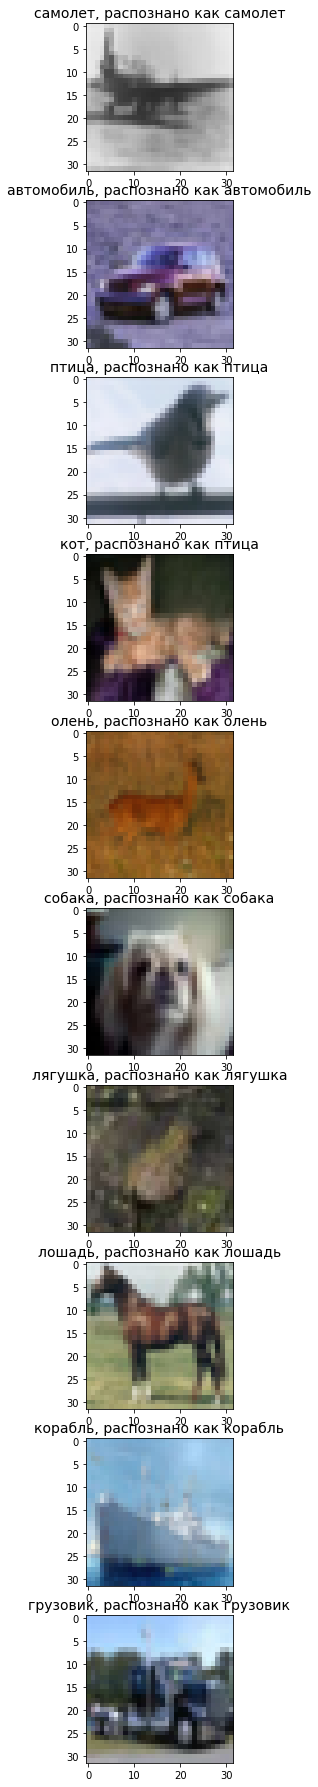

In [ ]:
#Выводим для примера картинки по каждому классу
print('Сеть распознала изображения: ')
fig, axs = plt.subplots(10, 1, figsize=(320, 32)) #Создаем полотно из 10 графиков
for i in range(10): #Проходим по классам от 0 до 9
  label_indexes = np.where(np.argmax(y_test, axis = 1)==i)[0] #Получаем список из индексов положений класса i в y_test
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = x_test[index] #Выбираем из x_train нужное изображение
  #выведем результат распознования для каждой картинки
  axs[i].set_title(classes[i] + ", распознано как " + classes[np.argmax(model(img[None,]))], fontdict={'size': 14})
  axs[i].imshow(img.reshape(32, 32, 3)) #Отображаем изображение i-ым графиков
plt.show() #Показываем изображения

**Итоги:** как видим созданная Полносвязная сеть состоящая из двух Dence слоев дала неплохой результат.